# LangGraph - Simple Graph
* Notebook by Adam Lang
* Date: 10/1/2024

# Simple Graphs in LangGraph
* This notebook was completed as part of the LangChain course "Intro to LangGraph".

# The Simplest Graph
* A simple graph here has 3 nodes and 1 conditional edge.
* As you can see, after Node 1, there is a "decision" to be made by the agent to go to Node 2 or Node 3 depending upon the logic result of Node 1.
* Source: LangGraph
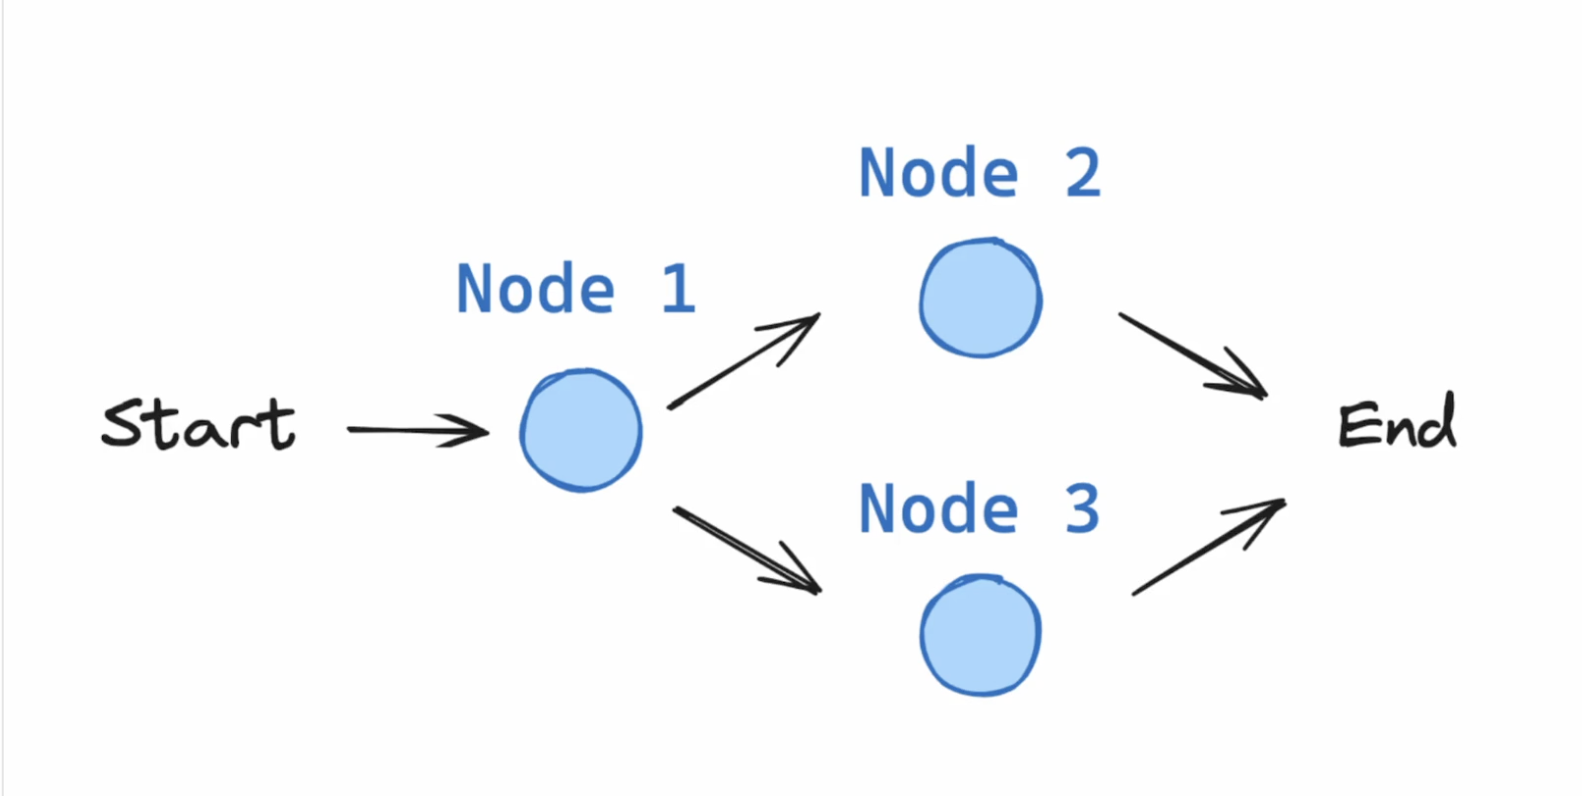

In [8]:
## install langgraph
%%capture --no-stderr
!pip install --quiet -U langgraph

# State
* The **State** is the first thing you define when building graphs.
  * The state schema is the **input schema** for all Nodes and Edges in the graph.
  * **This is what you are passing or moving between the nodes and edges of your graph!**
* This example below uses a simple dictionary with a single key `graph_state` as type `str`

In [3]:
from typing import TypedDict

## State schema
class State(TypedDict):
  ## 1 key: graph_state
  graph_state: str

# Nodes
* Nodes are just python functions.
* The first positional argument is the key **State** as above.
  * We can extract the **value** from the given state key in each node.
* Each node operates based on the given **State**.
* By default, each node will also **override the prior state value.**


In [4]:
## node 1
def node_1(state):
  print("---Node 1---")
  return {"graph_state": state['graph_state'] +" I am"} # overrides State


## node 2
def node_2(state):
  print("---Node 2---")
  return {"graph_state": state['graph_state'] +" happy!"} ##overrides state again

## node 3
def node_3(state):
  print("---Node 3---")
  return {"graph_state": state['graph_state'] +" sad!"}



# Edges
* Edges connect Nodes.
* Normal Edges are used if you want to always go from, for example:
  * `node_1` --> `node_2`
* **Conditional Edges** are used to optionally route between nodes.'
  * **This is the LOGIC that determines which node to go to next.**
  * A conditional edge is impelemented as a function that returns the NEXT node to visit based on some logic.

In [6]:
import random
from typing import Literal


## edge function
def decide_mood(state) -> Literal['node_2','node_3']:

  # often we will use state to decide on next node to visit
  user_input = state['graph_state']

  # logic here: 50/50 split between nodes 2 and 3
  if random.random() < 0.5:

    # 50% of the time we return Node 2
    return "node_2"

  # 50% of the time, we return Node 3
  return "node_3"

# Graph Construction
* Now we can build a graph!
* The **StateGraph** class is the main graph class from LangGraph that we will use.
* The steps to build a graph:
1. initialize `StateGraph` with `State` class from above.
2. Add **nodes** and **edges**
3. Use `START` node
  * special node that sends user input to the graph to indicate where to start the graph.
4. Use `END` node
  * special node that represents terminal node.
5. Compile graph
  * performs a few basic checks on structure of graph (e.g. no nodes left out or logic incorrect)

Lastly, we can visualize as Mermaid diagram.

In [9]:
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END

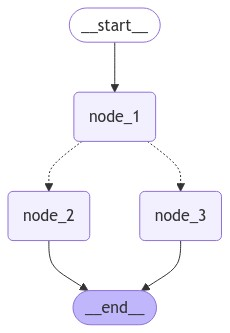

In [10]:
## build graph

##1. STATE
builder = StateGraph(State)
##2. NODES
builder.add_node("node_1", node_1)
builder.add_node("node_2", node_2)
builder.add_node("node_3", node_3)


## EDGES -- logic for graph
builder.add_edge(START, "node_1")
builder.add_conditional_edges("node_1", decide_mood) ## conditional edge
builder.add_edge("node_2", END)
builder.add_edge("node_3", END)

# Compile graph
graph = builder.compile()

## display graph
display(Image(graph.get_graph().draw_mermaid_png()))

# INVOKE the Graph
* The compiled graph implements the **runnable** protocol.
* This provides standard way to execute LangChain components.
* **invoke** is the standard method from LangChain to use here.
* The input is a dictionary:
  * `{"graph_state": "Hi, this is lance."}", which sets the initial value for our graph state dict.
* When `invoke` is called, the graph starts execution from the `START` node.
  * This moves through the defined nodes `(node_1, node_2, node_3)` in order.
  * The conditional edge will move from `node_1` to `node_2` or `3` using the 50/50 logic we defined.
* Each node function receives the current state and overrides it.
* The execution continues until it reaches the **END**node.  

In [13]:
## invoke the graph here with a starting STATE
graph.invoke({"graph_state" : "Hi, this is Lance."})

---Node 1---
---Node 3---


{'graph_state': 'Hi, this is Lance. I am sad!'}

In [16]:
## invoke the graph here with a starting STATE
graph.invoke({"graph_state" : "Hi, this is Lance."})

---Node 1---
---Node 2---


{'graph_state': 'Hi, this is Lance. I am happy!'}

# Summary
* `invoke` runs entire graph **synchronously**.
* This waits for each step to complete before moving to the next.
* It returns the final state of the graph after ALL NODES have executed.
* We can see above that based on the 50/50 logic we defined, it will pick a different node to edge path at random.